IMPORTING MODULES 

In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

READING THE DATASET

In [5]:
test_data = pd.read_csv("C:\\Users\\salsa\\OneDrive\\Desktop\\online_retail_II.csv", encoding  = 'ISO-8859-1')


In [6]:

test_data.rename(columns={'Customer ID':'CustomerID'},inplace = True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   CustomerID   824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


CLEANING AND PREPARING THE DATASET

In [ ]:
test_data = test_data.dropna(subset=["CustomerID"])
test_data.CustomerID = test_data.CustomerID.astype('int64')
test_data = test_data[test_data["Quantity"] > 0]
test_data.duplicated().any()
test_data.drop_duplicates(inplace=True)
test_data.shape


In [9]:
test_data.nunique()

Invoice        36975
StockCode       4631
Description     5283
Quantity         438
InvoiceDate    34591
Price            666
CustomerID      5881
Country           41
dtype: int64

In [10]:
filter = test_data[["Country","CustomerID"]].drop_duplicates()
print(filter.head())
filter.shape


           Country  CustomerID
0   United Kingdom       13085
12  United Kingdom       13078
31  United Kingdom       15362
54  United Kingdom       18102
71          France       12682


(5894, 2)

<Axes: xlabel='Country'>

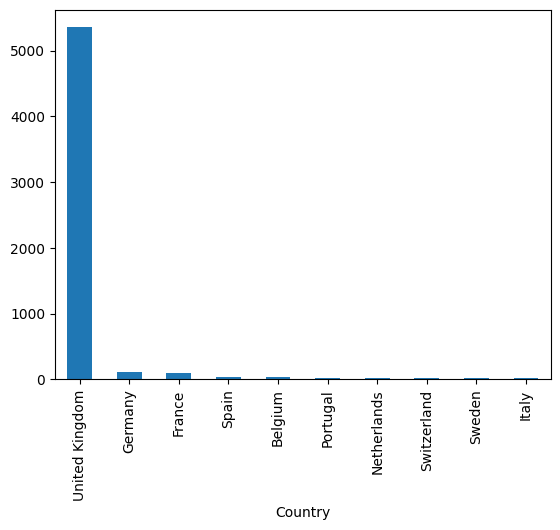

In [11]:
filter.Country.value_counts()[:10].plot(kind='bar')

In [12]:
final_data = test_data[test_data["Country"] == "United Kingdom"]
final_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [13]:
final_data.nunique()

Invoice        33546
StockCode       4616
Description     5249
Quantity         405
InvoiceDate    31562
Price            553
CustomerID      5353
Country            1
dtype: int64

PREPARE FOR THE RFM

In [14]:
final_data =final_data[["CustomerID","Invoice","InvoiceDate","Quantity","Price"]]
final_data["TotalPrice"] = final_data["Quantity"] * final_data["Price"]
final_data["InvoiceDate"] = pd.to_datetime(final_data['InvoiceDate'], format="ISO8601")
final_data.head()

,CustomerID,Invoice,InvoiceDate,Quantity,Price,TotalPrice
0,13085,489434,2009-12-01 07:45:00,12,6.95,83.4
1,13085,489434,2009-12-01 07:45:00,12,6.75,81.0
2,13085,489434,2009-12-01 07:45:00,12,6.75,81.0
3,13085,489434,2009-12-01 07:45:00,48,2.10,100.8
4,13085,489434,2009-12-01 07:45:00,24,1.25,30.0


In [15]:
present = datetime.now()
present


datetime.datetime(2024, 11, 19, 21, 0, 14, 495229)

In [16]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700434 entries, 0 to 1067354
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   CustomerID   700434 non-null  int64         
 1   Invoice      700434 non-null  object        
 2   InvoiceDate  700434 non-null  datetime64[ns]
 3   Quantity     700434 non-null  int64         
 4   Price        700434 non-null  float64       
 5   TotalPrice   700434 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 37.4+ MB


In [17]:
rfm = final_data.groupby("CustomerID").agg({"InvoiceDate":lambda date :(present-date.max()).days,
 "Invoice": lambda num : len(num),
 "TotalPrice" : lambda price : price.sum()})
rfm.head()


,InvoiceDate,Invoice,TotalPrice
CustomerID,,,
12346,5054,34,77556.46
12608,5133,16,415.79
12745,5215,22,723.85
12746,5269,17,254.55
12747,4731,249,8898.48


In [18]:
rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5353 entries, 12346 to 18287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    5353 non-null   int64  
 1   Frequency  5353 non-null   int64  
 2   Monetary   5353 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 167.3 KB


CREATING RFM QUARTILES 

In [19]:
rfm['r_quartile'] = pd.qcut(rfm['Recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['Recency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['Recency'], 4, ['4','3','2','1'])
rfm.head()


,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346,5054,34,77556.46,3,2,2
12608,5133,16,415.79,4,1,1
12745,5215,22,723.85,4,1,1
12746,5269,17,254.55,4,1,1
12747,4731,249,8898.48,1,4,4


In [20]:
rfm["RFM_Score"] = rfm.r_quartile.astype(str) + rfm.f_quartile.astype(str) +rfm.m_quartile.astype(str)
rfm.tail()

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
18283,4732,938,2664.90,1,4,4,144
18284,5160,28,461.68,4,1,1,411
18285,5389,12,427.00,4,1,1,411
18286,5205,67,1296.43,4,1,1,411
18287,4771,155,4182.99,2,3,3,233


In [21]:
rfm["RFM_Score"] = rfm['RFM_Score'].astype(int)
segment_labels = ['High-Value', 'Mid-Value','Low-Value']
rfm['Value_Segment'] = pd.qcut(rfm['RFM_Score'], q=3, labels=segment_labels)
rfm.head()

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score,Value_Segment
CustomerID,,,,,,,,
12346,5054,34,77556.46,3,2,2,322,Mid-Value
12608,5133,16,415.79,4,1,1,411,Low-Value
12745,5215,22,723.85,4,1,1,411,Low-Value
12746,5269,17,254.55,4,1,1,411,Low-Value
12747,4731,249,8898.48,1,4,4,144,High-Value


CREATING PLOT

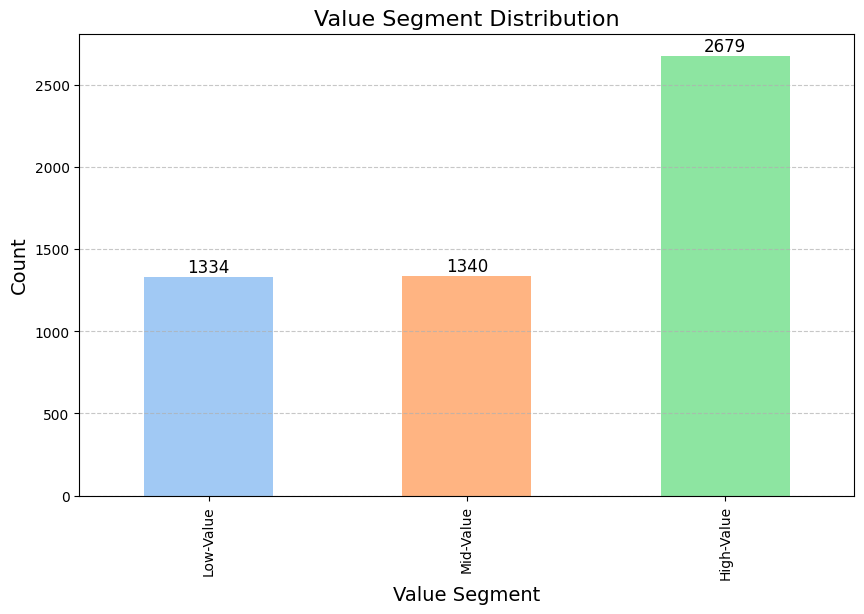

In [27]:
plt.figure(figsize=(10, 6)) 
value_seg = rfm.Value_Segment.value_counts().sort_values().plot(kind='bar', color= sns.color_palette("pastel"))
value_seg.set_title('Value Segment Distribution', fontsize=16) 
value_seg.set_xlabel('Value Segment', fontsize=14) 
value_seg.set_ylabel('Count', fontsize=14) 
value_seg.grid(axis='y', linestyle='--', alpha=0.7) 
for p in value_seg.patches:
    value_seg.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha='center', va='bottom', fontsize=12)
